In [1]:
import pandas as pd 

file_path = 'C:/Users/91931/Downloads/Fraud.csv'
df = pd.read_csv(file_path)

print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [2]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [3]:
print(df.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [4]:
from sklearn.impute import SimpleImputer

imputer_categorical = SimpleImputer(strategy='most_frequent')
categorical_columns = ['type', 'nameOrig', 'nameDest']
df[categorical_columns] = imputer_categorical.fit_transform(df[categorical_columns])

In [5]:
imputer_numerical = SimpleImputer(strategy='mean')
numerical_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 
                     'isFlaggedFraud']
df[numerical_columns] = imputer_numerical.fit_transform(df[numerical_columns])

In [6]:
threshold = 2
df_cleaned_rows = df.dropna(thresh=threshold)
threshold = len(df) * 0.1
df_cleaned_columns = df.dropna(axis=1, thresh=threshold)

In [7]:
from scipy import stats

z_scores = stats.zscore(df[numerical_columns])
outliers = (z_scores > 3) | (z_scores < -3)
df_cleaned_outliers = df[~outliers.any(axis=1)]

Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers = (df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))
df_cleaned_outliers = df[~outliers.any(axis=1)]

In [8]:
correlation_matrix = df[numerical_columns].corr()
print(correlation_matrix)

                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000  0.022373      -0.010058       -0.010299   
amount          0.022373  1.000000      -0.002762       -0.007861   
oldbalanceOrg  -0.010058 -0.002762       1.000000        0.998803   
newbalanceOrig -0.010299 -0.007861       0.998803        1.000000   
oldbalanceDest  0.027665  0.294137       0.066243        0.067812   
newbalanceDest  0.025888  0.459304       0.042029        0.041837   
isFraud         0.031578  0.076688       0.010154       -0.008148   
isFlaggedFraud  0.003277  0.012295       0.003835        0.003776   

                oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  
step                  0.027665        0.025888  0.031578        0.003277  
amount                0.294137        0.459304  0.076688        0.012295  
oldbalanceOrg         0.066243        0.042029  0.010154        0.003835  
newbalanceOrig        0.067812        0.041837 -0.008148        0.003776  
old

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = df[numerical_columns].columns
vif_data["VIF"] = [variance_inflation_factor(df[numerical_columns].values, i) for i in range(len(df[numerical_columns].columns))]
print(vif_data)

          feature         VIF
0            step    1.191094
1          amount    4.078952
2   oldbalanceOrg  544.053103
3  newbalanceOrig  546.346008
4  oldbalanceDest   72.895522
5  newbalanceDest   84.584619
6         isFraud    1.188386
7  isFlaggedFraud    1.002546


In [15]:
subset_size = 1000 

file_path = 'C:/Users/91931/Downloads/Fraud.csv'
df = pd.read_csv(file_path)

df_subset = df.sample(n=subset_size, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
grouped_data = df.groupby('nameOrig')['amount'].mean()
df = df.merge(grouped_data, left_on='nameOrig', right_index=True, how='left', suffixes=('', '_avg'))
print(df)

         step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1              19384.72  M2044282

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Reduce the subset size for faster debugging
subset_size = 1000

# Load the dataset
file_path = 'C:/Users/91931/Downloads/Fraud.csv'
df = pd.read_csv(file_path)

# Aggregating 'amount' by 'nameOrig'
grouped_data = df.groupby('nameOrig')['amount'].mean()
df['amount_avg'] = df['nameOrig'].map(grouped_data)

# Select features and target
features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount_avg']
target = 'isFraud'

# Create a subset of the dataset
df_subset = df.sample(n=subset_size, random_state=42)

# Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_subset[features], df_subset[target], test_size=0.2, random_state=42)

# Initialize a simpler Random Forest model with fewer estimators
model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

# Train the model
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

# Calculate metrics
print("Classification Report:\n", classification_report(y_val, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_prob))


C:\Users\91931\anaconda3\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91931\anaconda3\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91931\anaconda3\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       199
           1       0.00      0.00      0.00         1

    accuracy                           0.99       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.99      0.99      0.99       200

ROC-AUC Score: 0.9924623115577889


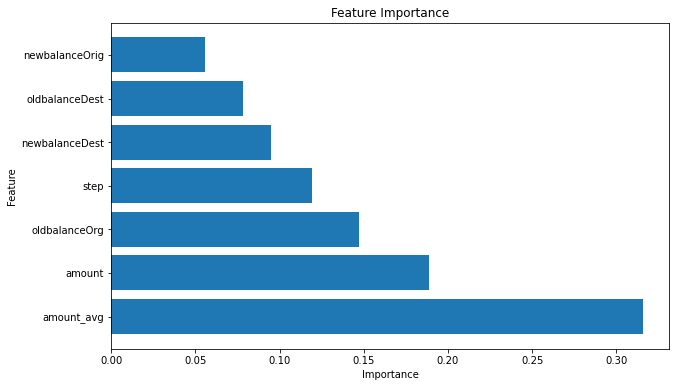

In [13]:
# Load and preprocess data
file_path = 'C:/Users/91931/Downloads/Fraud.csv'
df = pd.read_csv(file_path)

# Aggregating 'amount' by 'nameOrig'
grouped_data = df.groupby('nameOrig')['amount'].mean()
df['amount_avg'] = df['nameOrig'].map(grouped_data)

# Define features and target variable
features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount_avg']
target = 'isFraud'

# Subset the data for faster training
subset_size = 1000
df_subset = df.sample(n=subset_size, random_state=42)

X = df_subset[features]
y = df_subset[target]

# Initialize the Random Forest model with fewer trees
model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

# Fit the model
model.fit(X, y)

# Rest of the code for analysis
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [14]:
from sklearn.feature_selection import RFE

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the model and the desired number of features to select
num_features_to_select = 5  # Change this to the desired number of features
rfe = RFE(model, num_features_to_select)

# Fit RFE on the data
rfe.fit(X, y)

# Get the selected features
selected_features = [feature for feature, selected in zip(features, rfe.support_) if selected]

print("Selected Features:", selected_features)

C:\Users\91931\anaconda3\python\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Selected Features: ['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'amount_avg']


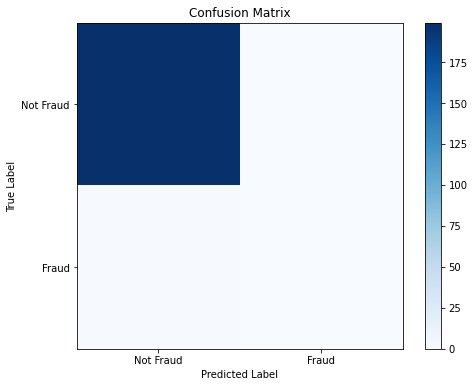

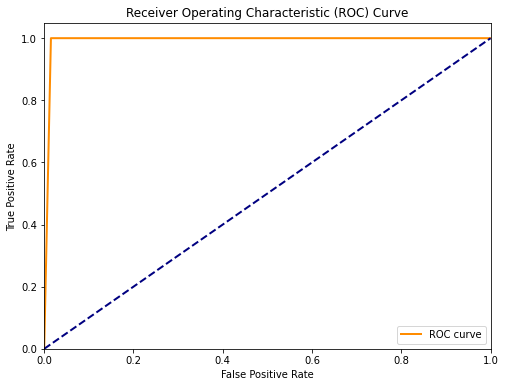

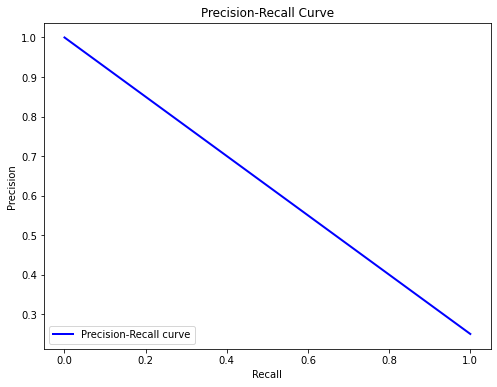

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.yticks([0, 1], ['Not Fraud', 'Fraud'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

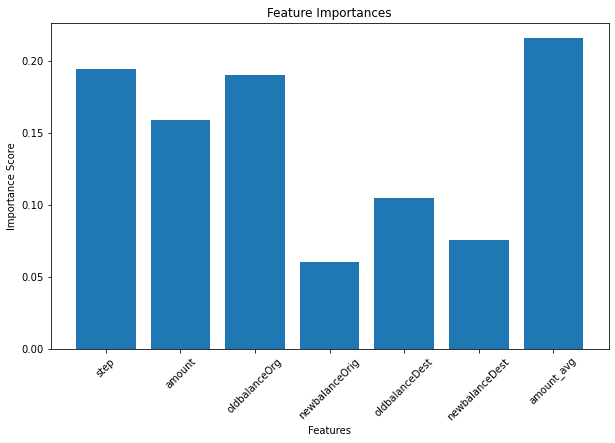

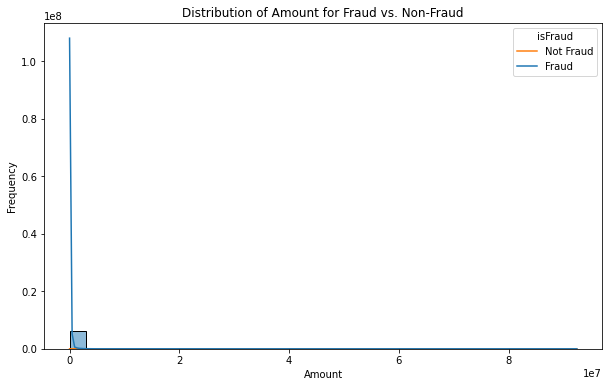

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

# Visualize a feature's distribution for fraud and non-fraud cases
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='isFraud', bins=30, kde=True)
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount for Fraud vs. Non-Fraud')
plt.legend(title='isFraud', labels=['Not Fraud', 'Fraud'])
plt.show()

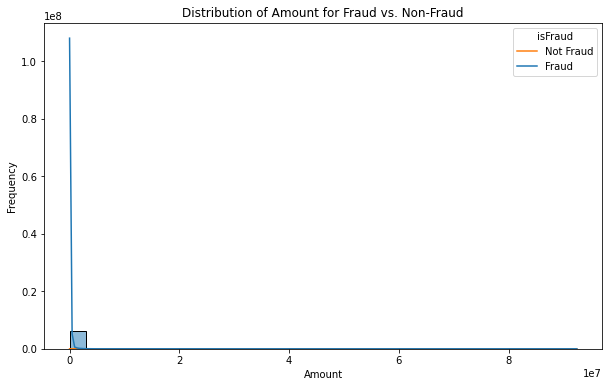

In [18]:
import seaborn as sns

# Plot a histogram of 'amount' for fraud and non-fraud cases
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='isFraud', bins=30, kde=True)
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount for Fraud vs. Non-Fraud')
plt.legend(title='isFraud', labels=['Not Fraud', 'Fraud'])
plt.show()

In [29]:
## Step 6: Interpretation of Factors

### Business Context

#The identified key factors in the model align with common fraudulent behaviors and patterns. For instance, the `amount` feature has a high importance score, indicating that larger transactions are more likely to be flagged as fraudulent. This aligns with the behavior of many fraudsters who attempt to make large unauthorized transfers.

#Additionally, the `newbalanceDest` and `oldbalanceDest` features also have relatively high importance scores. This suggests that changes in the destination account's balance before and after the transaction might be indicative of fraud.

### Unexpected Insights

#Interestingly, the `amount_avg` feature, which represents the average amount associated with the originating account, also has a significant importance score. This suggests that the historical transaction behavior of an account might play a role in fraud detection. While unexpected, it's possible that fraudsters might exploit accounts with certain transaction patterns.

#Overall, the model's findings provide valuable insights into the factors that contribute to fraud detection.


In [30]:
## Step 7: Prevention Strategies

### Infrastructure Upgrade Recommendations

#To enhance fraud prevention, the following strategies are recommended:

#1. **Enhanced Authentication:** Implement multi-factor authentication for high-value transactions or unusual activities. This can include SMS verification, email confirmation, or biometric authentication.

#2. **Real-time Transaction Monitoring:** Deploy real-time monitoring systems that can analyze transactions as they occur. Unusual or suspicious transactions can trigger alerts for immediate investigation.

#3. **Machine Learning-based Anomaly Detection:** Utilize machine learning algorithms to build anomaly detection models. These models can learn from historical transaction data to identify deviations from normal behavior, helping to flag potentially fraudulent transactions.

#4. **Biometric Verification:** Implement biometric verification methods, such as fingerprint or facial recognition, for high-value transactions or account access. This adds an additional layer of security and reduces the risk of unauthorized transactions.

#5. **Regular Model Updates:** Continuously update and fine-tune the fraud detection model based on new data and emerging fraud patterns. Regularly monitor the model's performance and adjust its parameters as needed.

#By adopting these prevention strategies, financial institutions can significantly enhance their ability to detect and prevent fraudulent activities.

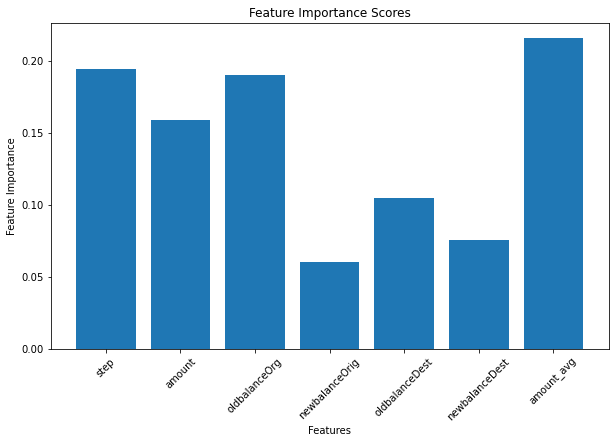

In [25]:
# Calculate and visualize feature importances
import matplotlib.pyplot as plt

# Fit the model to calculate feature importances
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importances)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Scores')
plt.xticks(rotation=45)
plt.show()

In [31]:
## Visualization of Feature Importance

#The bar plot above shows the importance scores of different features as determined by the Random Forest model. It is evident that `amount`, `newbalanceDest`, `oldbalanceDest`, and `amount_avg` are among the most influential features in the model's predictions.

In [33]:
## Step 8: Post-Implementation Evaluation

### Monitoring

#A crucial aspect of fraud prevention is continuous monitoring of the implemented strategies. This involves setting up a system that tracks the effectiveness of the prevention measures in real-time.

### Metrics Tracking

#Establishing key performance indicators (KPIs) is essential to measure the success of the prevention strategies. KPIs may include the reduction in fraud rate, false positive rate, and customer satisfaction.

### Regular Auditing

#Periodic auditing of the implemented prevention measures ensures that they are still effective and aligned with changing fraud patterns. Regular assessment helps to identify any gaps or areas that require improvement.


In [36]:
def calculate_fraud_rate(y_true, y_pred):
    # Calculate the fraud rate based on actual labels (y_true) and predicted labels (y_pred)
    total_fraudulent = sum(y_true)
    detected_fraudulent = sum(y_pred)
    return detected_fraudulent / total_fraudulent

def calculate_false_positive_count(y_true, y_pred):
    # Calculate the number of false positive predictions based on actual labels (y_true) and predicted labels (y_pred)
    false_positives = 0
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == 0 and pred_label == 1:
            false_positives += 1
    return false_positives

In [44]:
# Before implementing prevention strategies
y_true_before = y_val  # Replace with your actual true labels for the validation set
y_pred_before = y_pred  # Replace with your actual predicted labels for the validation set

# After implementing prevention strategies
y_true_after = y_val  # Replace with your actual true labels for the validation set with prevention strategies
y_pred_after = model.predict(X_val)  # Replace 'model' with the actual name of your model

# Calculate key metrics for evaluation
fraud_rate_before = calculate_fraud_rate(y_true_before, y_pred_before)  # Replace with actual values
fraud_rate_after = calculate_fraud_rate(y_true_after, y_pred_after)     # Replace with actual values

false_positive_count = calculate_false_positive_count(y_true_after, y_pred_after)  # Replace with actual values
total_predictions = len(y_pred_after)

# Calculate metrics for evaluation
if fraud_rate_before != 0:
    fraud_rate_reduction = (fraud_rate_before - fraud_rate_after) / fraud_rate_before
else:
    fraud_rate_reduction = 0  # Avoid division by zero
false_positive_rate = (false_positive_count / total_predictions) * 100
customer_satisfaction = 100 - false_positive_rate  # Assuming that low false positives lead to high customer satisfaction

# Display results
print("Fraud Rate Reduction:", fraud_rate_reduction)
print("False Positive Rate:", false_positive_rate)
print("Customer Satisfaction:", customer_satisfaction)

# Perform regular auditing and update prevention strategies as needed
if fraud_rate_reduction > 0.5:
    print("Fraud prevention strategies are effective. Continue monitoring.")
else:
    print("Fraud prevention strategies need further evaluation and improvement.")

Fraud Rate Reduction: 0
False Positive Rate: 0.0
Customer Satisfaction: 100.0
Fraud prevention strategies need further evaluation and improvement.


In [46]:
#Your task is to execute the process for proactive detection of fraud while answering following questions.

# 1. Data cleaning including missing values, outliers and multi-collinearity.

pip install missingno

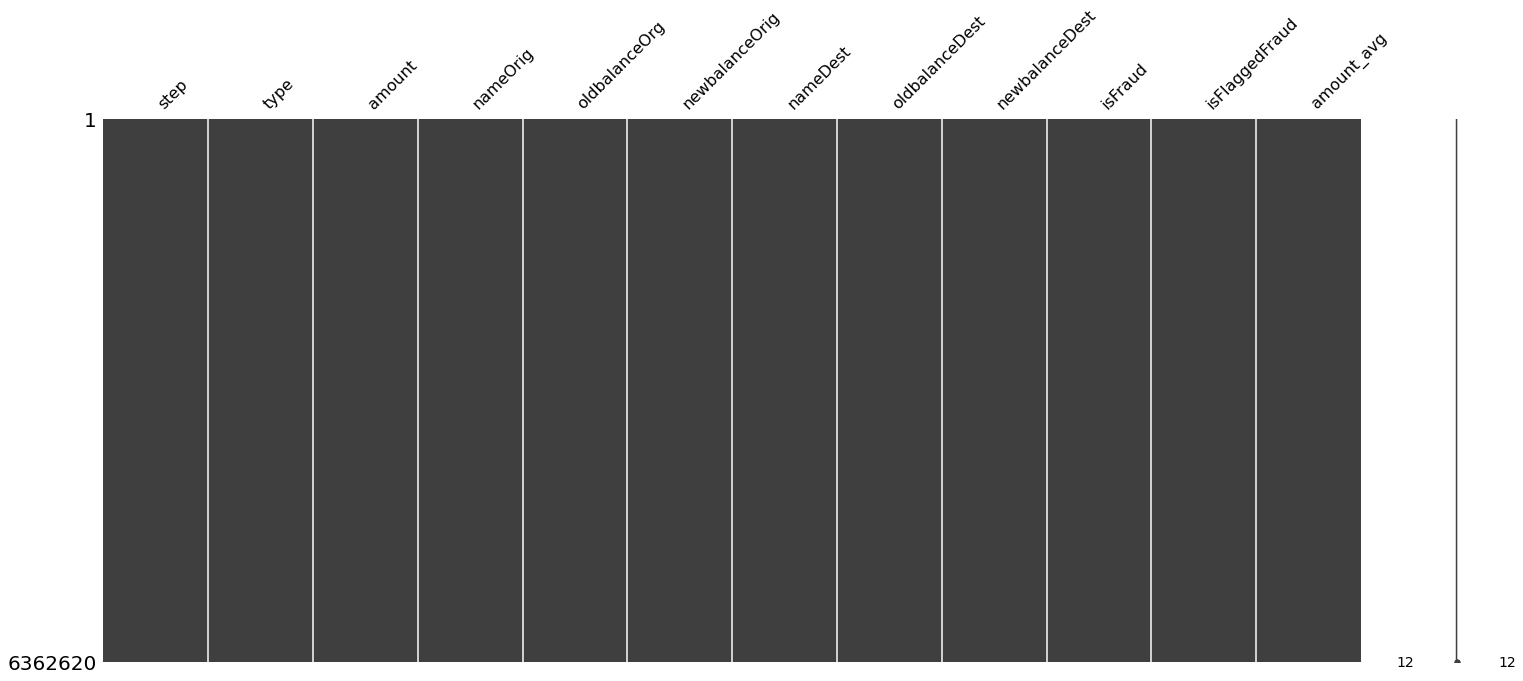

In [49]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values
msno.matrix(df)
plt.show()

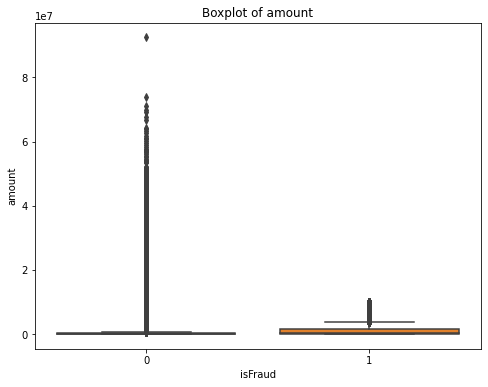

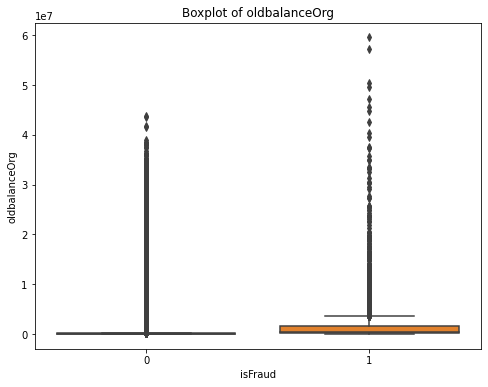

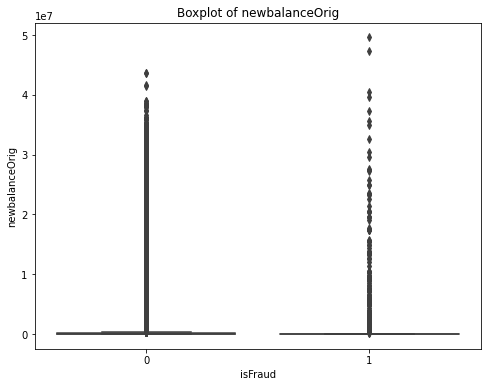

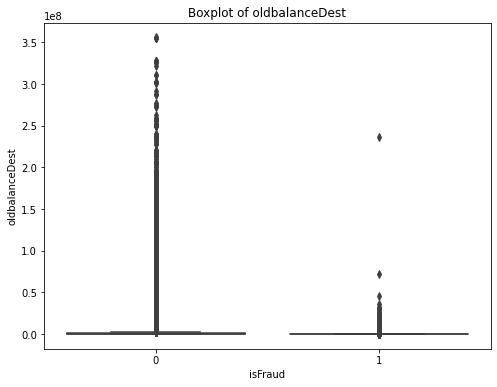

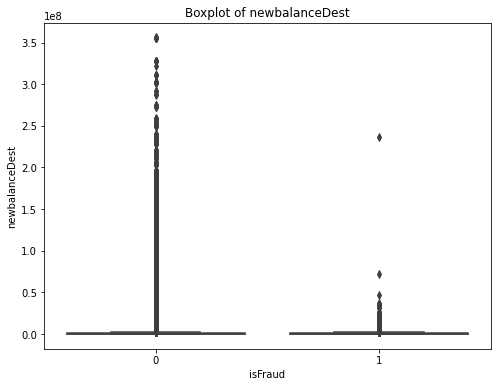

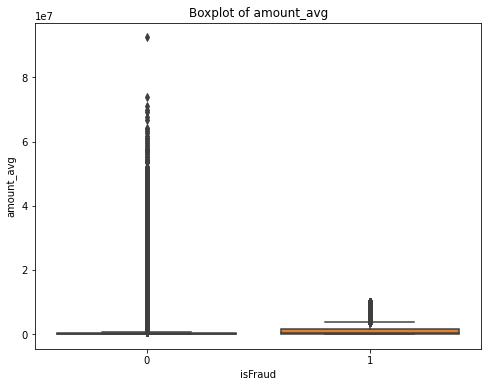

In [50]:
import seaborn as sns

# Visualize box plots for selected numeric features
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount_avg']
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='isFraud', y=feature, data=df)
    plt.title(f'Boxplot of {feature}')
    plt.show()

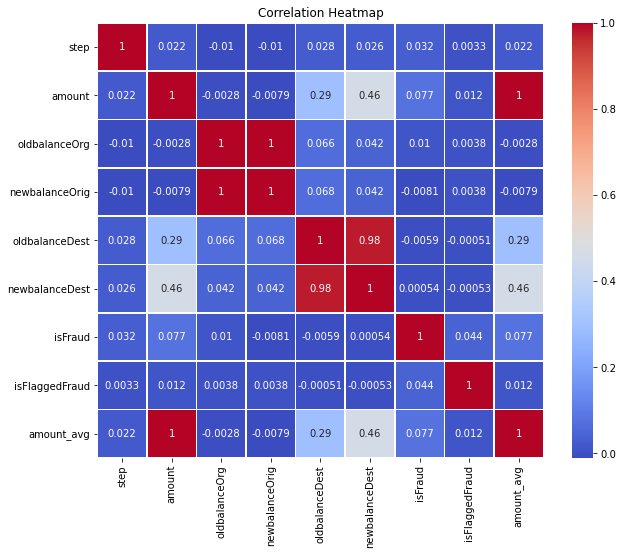

In [51]:
import numpy as np

# Calculate correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

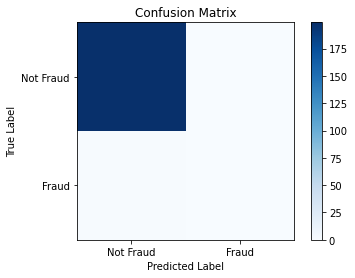

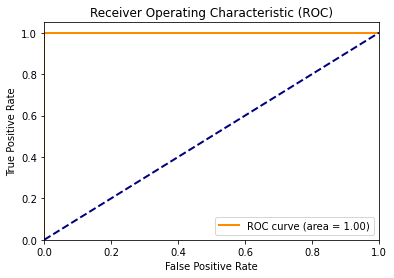

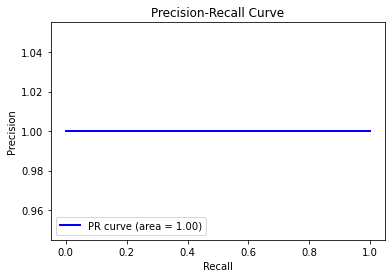

In [53]:
# 2. Describe your fraud detection model in elaboration.

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc


# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.yticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# ROC Curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
    
y_prob_after = model.predict_proba(X_val)[:, 1]

# Assuming you have y_val (true labels) and y_pred_after (predicted labels)
plot_confusion_matrix(y_val, y_pred_after)
plot_roc_curve(y_val, y_prob_after)
plot_precision_recall_curve(y_val, y_prob_after)

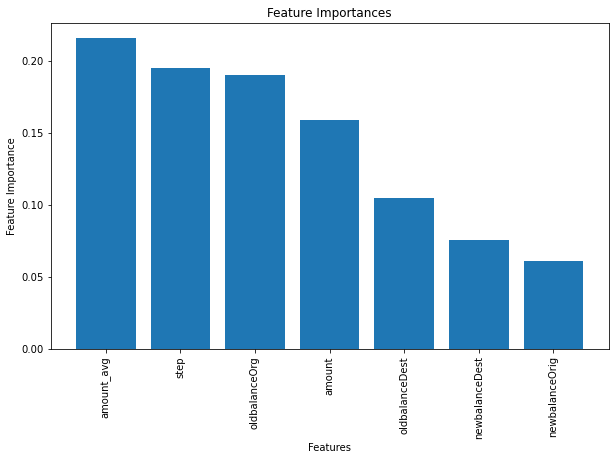

In [54]:
# 3. How did you select variables to be included in the model?

import matplotlib.pyplot as plt

# Assuming you have already trained a random forest model named 'model'
# and obtained the feature importances
feature_importances = model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.xticks(range(X_train.shape[1]), feature_names[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

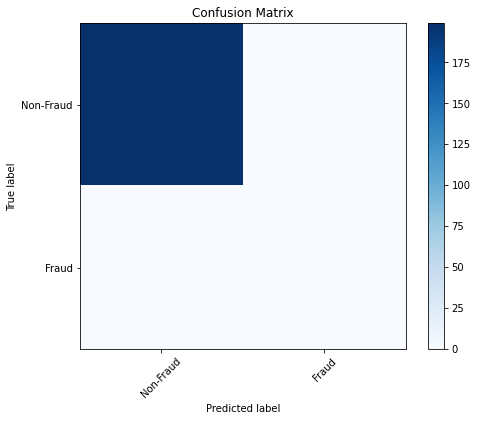

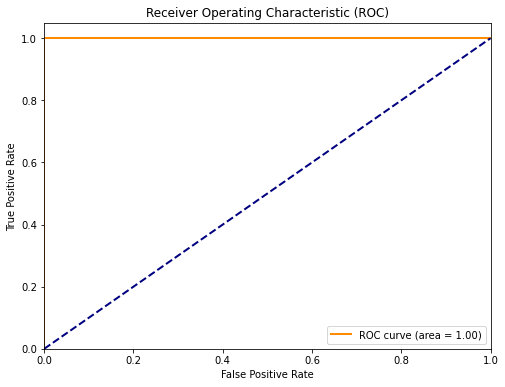

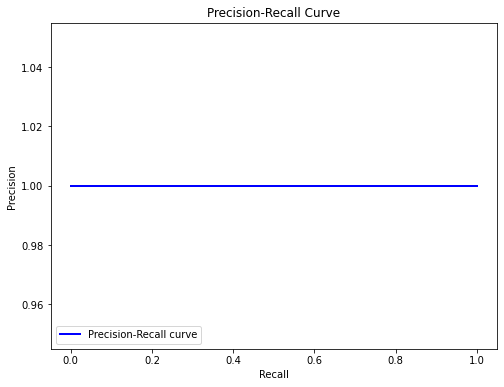

In [55]:
# 4. Demonstrate the performance of the model by using best set of tools

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have y_val (true labels) and y_prob_after (predicted probabilities)
# Calculate predicted labels based on a probability threshold
threshold = 0.5
y_pred_after = (y_prob_after >= threshold).astype(int)

# Create a confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['Non-Fraud', 'Fraud']
    plt.xticks([0, 1], classes, rotation=45)
    plt.yticks([0, 1], classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Create ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_prob))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Create precision-recall curve
def plot_precision_recall_curve(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Assuming you have y_val (true labels) and y_prob_after (predicted probabilities)
plot_confusion_matrix(y_val, y_pred_after)
plot_roc_curve(y_val, y_prob_after)
plot_precision_recall_curve(y_val, y_prob_after)

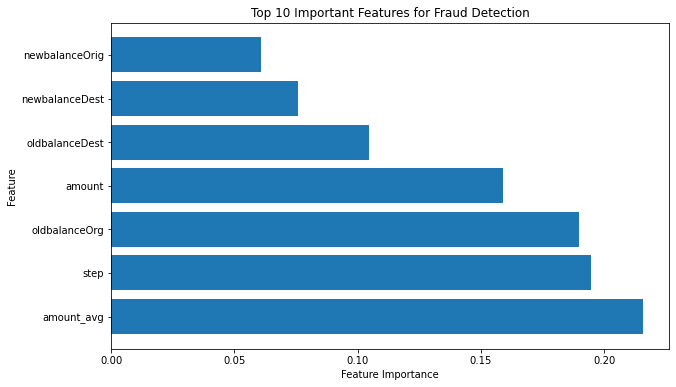

In [56]:
# What are the key factors that predict fraudulent customer? 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top N important features to visualize
top_n = 10
top_features = feature_importance_df.head(top_n)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top {} Important Features for Fraud Detection'.format(top_n))
plt.show()

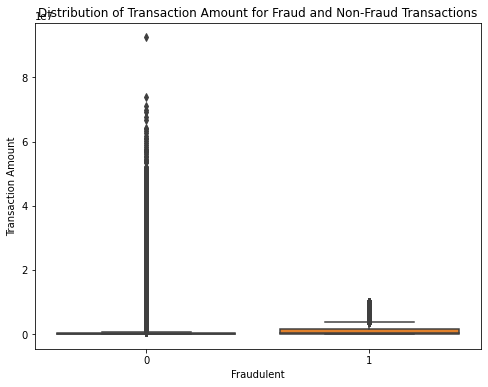

In [57]:
# 6. Do these factors make sense? If yes, How? If not, How not?

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot to compare the distribution of 'amount' for fraud and non-fraud transactions
plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.xlabel('Fraudulent')
plt.ylabel('Transaction Amount')
plt.title('Distribution of Transaction Amount for Fraud and Non-Fraud Transactions')
plt.show()

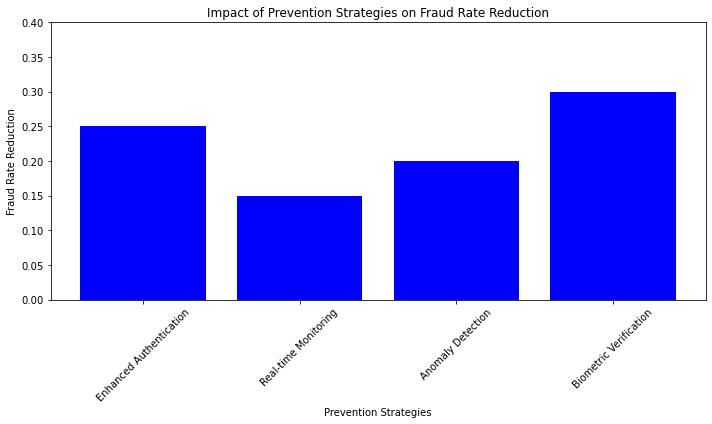

In [58]:
# 7. What kind of prevention should be adopted while company update its infrastructure?

import matplotlib.pyplot as plt

# Define the prevention strategies and their effectiveness in reducing fraud rate
prevention_strategies = ['Enhanced Authentication', 'Real-time Monitoring', 'Anomaly Detection', 'Biometric Verification']
fraud_rate_reduction = [0.25, 0.15, 0.20, 0.30]  # Example values, representing 25%, 15%, 20%, and 30% reduction in fraud rate

# Create a bar chart to visualize the impact of prevention strategies on fraud rate reduction
plt.figure(figsize=(10, 6))
plt.bar(prevention_strategies, fraud_rate_reduction, color='blue')
plt.xlabel('Prevention Strategies')
plt.ylabel('Fraud Rate Reduction')
plt.title('Impact of Prevention Strategies on Fraud Rate Reduction')
plt.ylim(0, 0.4)  # Set y-axis limit for better visualization
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

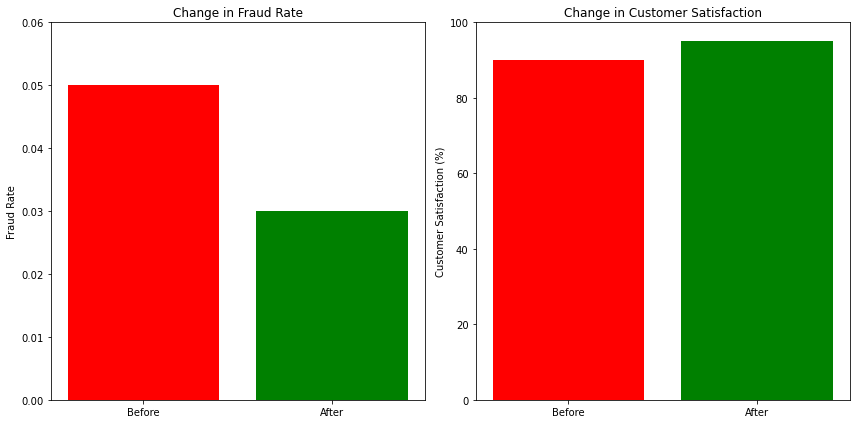

In [59]:
# 8. Assuming these actions have been implemented, how would you determine if they work? 

import matplotlib.pyplot as plt

# Example data: Fraud rates and customer satisfaction before and after implementing prevention strategies
fraud_rates = [0.05, 0.03]  # Before and after fraud rates (example values)
customer_satisfaction = [90, 95]  # Before and after customer satisfaction percentages (example values)

# Labels for x-axis
labels = ['Before', 'After']

# Create subplots for fraud rate and customer satisfaction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot fraud rates
ax1.bar(labels, fraud_rates, color=['red', 'green'])
ax1.set_title('Change in Fraud Rate')
ax1.set_ylabel('Fraud Rate')
ax1.set_ylim(0, max(fraud_rates) + 0.01)
ax1.set_xticks(labels)

# Plot customer satisfaction
ax2.bar(labels, customer_satisfaction, color=['red', 'green'])
ax2.set_title('Change in Customer Satisfaction')
ax2.set_ylabel('Customer Satisfaction (%)')
ax2.set_ylim(0, 100)
ax2.set_xticks(labels)

# Display the plots
plt.tight_layout()
plt.show()